In [11]:
from DETR_model import DinoDetrMaskMul
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from polygon import RasLoss, SoftPolygon
from Loader_17 import DAVIS_Rawset, DAVIS_Infer, DAVIS_Dataset
import logging
import json
from MyLoss import deviation_loss, get_edges
from tenLoader import normalize
from tqdm import tqdm

In [2]:
train_rawset = DAVIS_Rawset(is_train=True)
val_rawset =DAVIS_Rawset(is_train=False)

In [14]:
model_name = "DETR_davis_mb_std"
log_path = f"./log/{model_name}.log"
logging.basicConfig(
    filename=log_path,
    level=logging.INFO,
    format="%(asctime)s %(levelname)-8s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logging.info(f"Start training {model_name}")

In [3]:
# load the dataset

train_rawset.data_set = train_rawset.data_set[:10]

train_dataset = DAVIS_Dataset(train_rawset)
train_infer = DAVIS_Infer(train_rawset)


val_rawset.data_set = val_rawset.data_set[:10]

val_infer = DAVIS_Infer(val_rawset)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [5]:
unshuffle_train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)

In [6]:
def total_len_loss(pred_bou: torch.Tensor, max_coord=224) -> torch.Tensor:
    pred_bou = pred_bou / max_coord
    pred_edges = get_edges(pred_bou)
    return pred_edges.mean()

In [12]:
# load the model
model = DinoDetrMaskMul(mul_before=True).cuda()

# load the loss function
ras_loss = RasLoss().cuda()

# load the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
train_total_loss_dict = {}
train_dif_loss_dict = {}
train_std_loss_dict = {}
train_len_loss_dict = {}
train_iou_dict = {}
val_iou_dict = {}
best_val_iou = 0
interval_epochs = 15
interval_steps = 3
epoch_index = 0

In [15]:
for interval in range(interval_steps):
    for e in range(interval_epochs):
        model.train()
        mean_total_loss = 0
        mean_dif_loss = 0
        mean_std_loss = 0
        mean_len_loss = 0
        for (
            video_idx,
            frame_idx,
            fir_img,
            fir_sgm,
            pre_img,
            pre_sgm,
            cur_img,
            cur_sgm,
        ) in tqdm(train_loader):
            optimizer.zero_grad()
            fir_img = fir_img.cuda()
            fir_sgm = fir_sgm.cuda()
            pre_img = pre_img.cuda()
            pre_sgm = pre_sgm.cuda()
            cur_img = cur_img.cuda()
            cur_sgm = cur_sgm.cuda()
            pred_bou = model(fir_img, fir_sgm, pre_img, pre_sgm, cur_img)
            dif_loss = ras_loss(pred_bou, cur_sgm)
            std_loss = deviation_loss(pred_bou)
            len_loss = total_len_loss(pred_bou)
            loss = 0.33 * dif_loss + 0.33 * std_loss + 0.33 * len_loss
            loss.backward()
            optimizer.step()
            mean_total_loss += loss.item()
            mean_dif_loss += dif_loss.item()
            mean_std_loss += std_loss.item()
            mean_len_loss += len_loss.item()
        mean_total_loss /= len(train_loader)
        mean_dif_loss /= len(train_loader)
        mean_std_loss /= len(train_loader)
        mean_len_loss /= len(train_loader)
        train_total_loss_dict[epoch_index] = mean_total_loss
        train_dif_loss_dict[epoch_index] = mean_dif_loss
        train_std_loss_dict[epoch_index] = mean_std_loss
        train_len_loss_dict[epoch_index] = mean_len_loss
        print(f"Epoch {epoch_index}, Dif Loss: {mean_dif_loss}")
        print(f"Epoch {epoch_index}, Std Loss: {mean_std_loss}")
        print(f"Epoch {epoch_index}, Len Loss: {mean_len_loss}")
        print(f"Epoch {epoch_index}, total Loss: {mean_total_loss}")
        with open(f"./log/{model_name}_total_loss.json", "w") as f:
            json.dump(train_total_loss_dict, f)
        with open(f"./log/{model_name}_dif_loss.json", "w") as f:
            json.dump(train_dif_loss_dict, f)
        with open(f"./log/{model_name}_std_loss.json", "w") as f:
            json.dump(train_std_loss_dict, f)
        with open(f"./log/{model_name}_len_loss.json", "w") as f:
            json.dump(train_len_loss_dict, f)
        # save the model
        torch.save(
            model.state_dict(),
            f"./model/{model_name}.pth",
        )
        logging.info(f"Epoch {epoch_index}, Dif Loss: {mean_dif_loss}")
        logging.info(f"Epoch {epoch_index}, Std Loss: {mean_std_loss}")
        logging.info(f"Epoch {epoch_index}, Len Loss: {mean_len_loss}")
        logging.info(f"Epoch {epoch_index}, total Loss: {mean_total_loss}")
        epoch_index += 1
    train_infer.infer_model(model)
    train_iou = train_infer.get_total_iou()
    train_iou_dict[epoch_index] = train_iou
    val_infer.infer_model(model)
    val_iou = val_infer.get_total_iou()
    val_iou_dict[epoch_index] = val_iou
    print(f"Epoch {epoch_index}, Train IoU: {train_iou}, Val IoU: {val_iou}")
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(
            model.state_dict(),
            f"./model/{model_name}_best.pth",
        )
    logging.info(f"Epoch {epoch_index}, Train IoU: {train_iou}, Val IoU: {val_iou}")
    with open(f"./log/{model_name}_train_iou.json", "w") as f:
        json.dump(train_iou_dict, f)
    with open(f"./log/{model_name}_val_iou.json", "w") as f:
        json.dump(val_iou_dict, f)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:07<00:00, 29.09it/s]


Epoch 0, Dif Loss: 0.4384287278826644
Epoch 0, Std Loss: 0.03119493069626936
Epoch 0, Len Loss: 0.03621102754117512
Epoch 0, total Loss: 0.1669254538126108


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:07<00:00, 28.77it/s]


Epoch 1, Dif Loss: 0.3907863971663684
Epoch 1, Std Loss: 0.028966607739467447
Epoch 1, Len Loss: 0.031136893771770525
Epoch 1, total Loss: 0.14879367227961376


 36%|██████████████████████████████████████████████████▏                                                                                          | 73/205 [00:02<00:04, 28.43it/s]


KeyboardInterrupt: 

In [205]:
(
    video_idx,
    frame_idx,
    fir_img,
    fir_sgm,
    pre_img,
    pre_sgm,
    cur_img,
    cur_sgm,
) = next(iter(train_loader))
fir_img.shape, fir_sgm.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4, 224, 224]))

In [206]:
pred_bou = model(
    fir_img.cuda(),
    fir_sgm.cuda(),
    pre_img.cuda(),
    pre_sgm.cuda(),
    cur_img.cuda(),
)
pred_bou.shape

torch.Size([4, 80, 2])

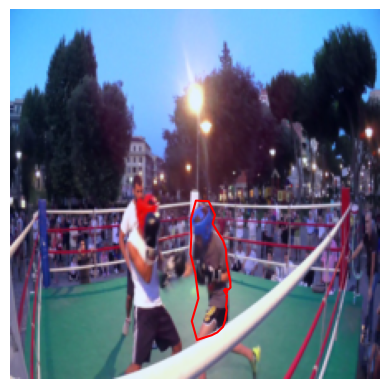

In [207]:
plt.imshow(
    normalize(
        cur_img[0].permute(1, 2, 0).cpu().detach().numpy(),
    ),
)
plt.axis("off")
plt.plot(
    pred_bou[0, :, 0].cpu().detach().numpy(),
    pred_bou[0, :, 1].cpu().detach().numpy(),
    "r",
)
plt.show()

In [216]:
pred_edges = get_edges(pred_bou)[0].cpu().detach().numpy()
pred_edges.mean()

2.7716272

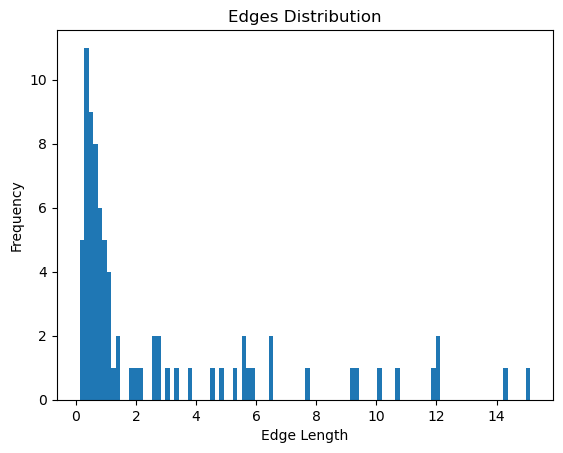

In [215]:
# show edges distribution
plt.hist(pred_edges, bins=100)
# label x and y axis
plt.xlabel("Edge Length")
plt.ylabel("Frequency")
plt.title("Edges Distribution")
plt.show()